In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import functorch
import matplotlib.pyplot as plt

import os
from datetime import datetime
import time

import Double_Pendulum.Lumped_Mass.robot_parameters as robot_parameters
import Double_Pendulum.Lumped_Mass.transforms as transforms
import Double_Pendulum.Lumped_Mass.dynamics as dynamics
import Learning.loss_terms as loss_terms
import Plotting.plotters as plotters


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rp = robot_parameters.LUMPED_PARAMETERS
print(rp)

{'l1': 2, 'l2': 2, 'm': 3, 'g': 9.81, 'xa': 5, 'ya': 1}


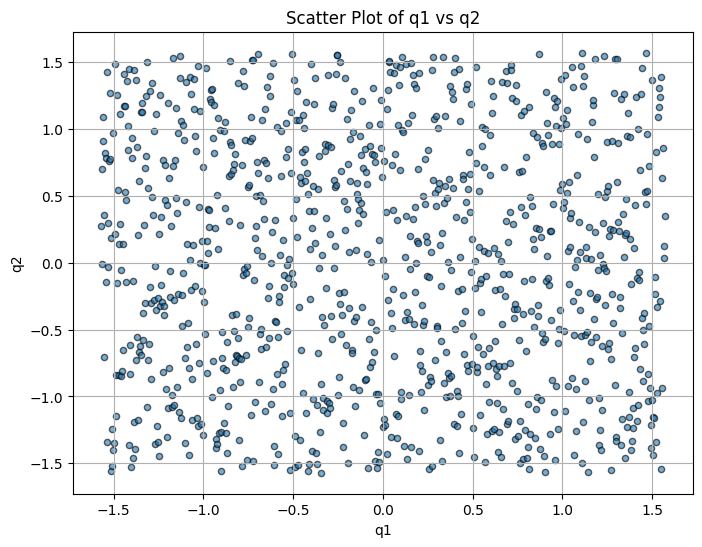

In [4]:
import numpy as np

# Number of samples
q1_low  = -torch.pi/2
q1_high = torch.pi/2
q2_low  = -torch.pi/2
q2_high = torch.pi/2
q1_d_low  = -torch.pi
q1_d_high = torch.pi
q2_d_low  = -torch.pi
q2_d_high = torch.pi


n_samples = 1000

# Generate uniformly distributed points for q1 and q2
q1 = torch.linspace(q1_low, q1_high, n_samples)
q2 = torch.linspace(q2_low, q2_high, n_samples)
q1_d = torch.linspace(q1_d_low, q1_d_high, n_samples)
q2_d = torch.linspace(q2_d_low, q2_d_high, n_samples)

idx = torch.randperm(q2.shape[0])
idx2 = torch.randperm(q1_d.shape[0])
idx3 = torch.randperm(q2_d.shape[0])

q2 = q2[idx]
q1_d = q1_d[idx2]
q2_d = q2_d[idx3]

# Stack q1 and q2 to get the 2D coordinates
points = torch.stack([q1, q2, q1_d, q2_d], axis=1)#.to(device)  # Shape will be (1000, 2)


"""
# Define conditions for exclusion
q1_condition = (q1 >= -1.5) & (q1 <= -0.5)  # Points where q1 is between -1.5 and -0.5
q2_condition = (q2 >= 1.5) & (q2 <= 2.5)    # Points where q2 is between 1.5 and 2.5

# Combine conditions to exclude points where both conditions are True
exclude_mask = q1_condition & q2_condition

# Apply the mask to filter out unwanted points
# Keep points where exclude_mask is False
points = points[~exclude_mask]
"""


# Plot q1 vs q2
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0].numpy(), points[:, 1].numpy(), alpha=0.6, edgecolors='k', s=20)
plt.title('Scatter Plot of q1 vs q2')
plt.xlabel('q1')
plt.ylabel('q2')
plt.grid(True)
plt.show()

In [5]:
# Split into training and test sets (80% train, 20% test)
train_part = 0.8
train_size = int(train_part * len(points))
test_size = len(points) - train_size

train_points, test_points = torch.split(points, [train_size, test_size])

# Create TensorDataset for both training and testing sets
train_dataset = TensorDataset(train_points)
test_dataset = TensorDataset(test_points)

# Create the DataLoader for both training and testing sets
batch_size = 64
train_dataloader = DataLoader(train_dataset, 
                               batch_size=batch_size, 
                               shuffle=True,
                               num_workers=0,
                               pin_memory=True)

test_dataloader = DataLoader(test_dataset, 
                              batch_size=batch_size, 
                              shuffle=False,
                              num_workers=0,
                              pin_memory=True)


# Example usage: iterate through the DataLoader
for batch in train_dataloader:
    #print(batch[0])
    break  # Just to show one batch

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, rp):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.Sigmoid(),
            nn.Linear(4, 4),
            nn.Sigmoid(),
            nn.Linear(4, 1)
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 2),
            nn.Sigmoid(),
            nn.Linear(2, 2),
            nn.Sigmoid(),
            nn.Linear(2, 2)
        )
        
        self.rp = rp
        
    def encoder_theta_1_ana(self, q):
        theta_1 = transforms.analytic_theta_1(self.rp, q).unsqueeze(0)
        return theta_1, theta_1
    
    
    #This function is not used in the forward pass, but is useful for comparing learned to analytic theta_2
    def encoder_theta_2_ana(self, q):
        theta_2 = transforms.analytic_theta_2(self.rp, q).unsqueeze(0)
        return theta_2, theta_2

    def encoder_nn(self, q):
        theta_2 = self.encoder(q)
        return theta_2, theta_2
    
    def forward(self, q):
        
        J_h_1, theta_1 = torch.vmap(torch.func.jacfwd(self.encoder_theta_1_ana, has_aux=True))(q)
        
        J_h_2, theta_2 = torch.vmap(torch.func.jacfwd(self.encoder_nn, has_aux=True))(q)


        J_h_2_ana, theta_2_ana = torch.vmap(torch.func.jacfwd(self.encoder_theta_2_ana, has_aux=True))(q)
        
        theta = torch.stack((theta_1, theta_2), dim=1).squeeze(2)
        J_h = torch.cat((J_h_1, J_h_2), dim=1)
        J_h_ana = torch.cat((J_h_1, J_h_2_ana), dim=1)

        q_hat = self.decoder(theta)
        return(theta, J_h, q_hat, J_h_ana)

In [7]:
%%time
%matplotlib widget

current_time = datetime.now().strftime("%Y%m%d%H%M")
save_directory = os.path.join(os.getcwd(), "Models")
os.makedirs(save_directory, exist_ok=True)
file_name = f"Lumped_Mass_{current_time}.pth"
file_path = os.path.join(save_directory, file_name)

load_path = os.path.normpath("/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202411271337.pth")


rp = robot_parameters.LUMPED_PARAMETERS
num_epochs = 1201

print(file_path)
model = Autoencoder(rp).to(device)  # Move model to GPU
#model.load_state_dict(torch.load(load_path, weights_only=True))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)#, weight_decay=1e-6)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-2, alpha=0.99, eps=1e-08)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5 ** (1 / num_epochs))



l_weights = [1,
             1,
             1e-1,
             1e-2]
outputs = []



plt.ion()

for epoch in range(num_epochs):
    for index, batch in enumerate(train_dataloader):
        batch_size = batch[0].shape[0]
        q = batch[0][:, 0:2].to(device)
        q.requires_grad = True
        q_d = batch[0][:, 2:4].to(device)
        
        theta, J_h, q_hat, J_h_ana = model(q)  
                
        matrices_vmap = torch.vmap(dynamics.dynamical_matrices, 
                                   in_dims=(None, 0, 0))

        M_q, C_q, G_q = matrices_vmap(rp, q, q_d)
        
        M_th, C_th, G_th = transforms.transform_dynamical_matrices(M_q, C_q, G_q, J_h, device)      
        
        #loss_reconstruction = loss_terms.loss_reconstruction(q, q_hat)
        loss_diagonality_geo_mean = loss_terms.loss_diagonality_geo_mean(M_th, batch_size, device)
        #loss_diagonality_trace = loss_terms.loss_diagonality_trace(M_th, batch_size, device)
        #loss_diagonality_smallest = loss_terms.loss_diagonality_smallest(M_th, batch_size, device)
        ### Use J@J^T = eye to avoid needing to calculate the Jacobian inverse for efficiency. 
        loss_J_h_unitary = loss_terms.loss_J_h_unitary(J_h, batch_size, device)
        loss_J_h_cheat = loss_terms.loss_J_h_cheat(J_h, J_h_ana)
        #loss_M_th_cheat = loss_terms.loss_M_th_cheat(M_th, rp, q, q_d, batch_size)
        #l1_norm = loss_terms.loss_l1(model)
        
        #loss_diagonality = 10 * loss_diagonality_geo_mean + loss_diagonality_smallest + 100 * loss_diagonality_trace
        loss_diagonality = loss_diagonality_geo_mean


        loss = loss_diagonality + 0.1 * loss_J_h_unitary
        loss = loss_J_h_cheat

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()




    if torch.sum(torch.isnan(J_h)) > 0:
        print("UHOHHHH")
        break  

    if epoch % 100 == 0:
        print(f'Epoch:{epoch+1}, Loss:{loss.item():.9f}')#, LR:{scheduler.get_last_lr():.7f}')
        print("Weighted loss_diagonality_geo_mean:", loss_diagonality_geo_mean.item())
        #print("Weighted loss_diagonality_smallest:", loss_diagonality_smallest)
        #print("Weighted loss_diagonality_trace:", 100 * loss_diagonality_trace)
        print("Weighted loss Jh unitary:", 0.1 * loss_J_h_unitary.item())
    if epoch % 600 == 0 and epoch > 0:
        plotters.plot_h2(model, device, rp, epoch)
        plotters.plot_J_h(model, device, rp, epoch, plot_index = 0)
        plotters.plot_J_h(model, device, rp, epoch, plot_index = 1)
        plotters.plot_decoupling(model, device, rp, epoch)
    scheduler.step()

    outputs.append((epoch, loss, q, q_hat, theta, M_th))


torch.save(model.state_dict(), file_path)
print(f"Model parameters saved to {file_path}")

/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202411301635.pth


NameError: name 'weight' is not defined

In [8]:
epoch = 1
plotters.plot_decoupling(model, device, rp, epoch)

NameError: name 'weight' is not defined

In [ ]:
q_test = torch.tensor([[2, -0.]]).to(device)
theta, J_h, q_hat, J_h_ana = model(q_test)

J_h_inv = torch.linalg.pinv(J_h)
J_h_inv_trans = J_h_inv.transpose(1, 2)




print("J_h:\n", J_h.detach().cpu().numpy()[0])
print("J_h_inv:\n", J_h_inv.detach().cpu().numpy()[0])

M_q, C_q, G_q = dynamics.dynamical_matrices(rp, q_test[0], q_test[0])
M_q = M_q.unsqueeze(0)
M_th, C_th, G_th = transforms.transform_dynamical_matrices(M_q, C_q, G_q, J_h, device)
print("M_q:", M_q)
print("M_th:\n", M_th)


off_dia = M_th[:, 1,0]
diag_elements = M_th[:, [0, 1], [0, 1]]
diag_product = torch.sqrt(diag_elements[:, 0] * diag_elements[:, 1] + 1e-6)
M_th_ratio = off_dia/diag_product
print("M_th_ratio:", M_th_ratio)

print("M_q:\n", M_q)

print("J_h_ana:\n", J_h_ana.detach().cpu().numpy()[0], "\n")
J_h_ana_inv = torch.linalg.pinv(J_h_ana)
J_h_ana_inv_trans = J_h_ana_inv.transpose(1,2)

print("J_h_ana_inv:\n", J_h_ana_inv.detach().cpu().numpy()[0], "\n")


M_th_ana, C_th_ana, G_th_ana = dynamics.dynamical_matrices_th(rp, q_test[0], q_test[0]) 
print("M_th_ana:", M_th_ana.detach().cpu().numpy())

J_h:
 [[ 1.6046147   0.41778404]
 [ 0.0259409  -0.03623533]]
J_h_inv:
 [[  0.525291     6.0564733 ]
 [  0.37605622 -23.261547  ]]
M_q: tensor([[[12.0000, -4.9938],
         [-4.9938, 12.0000]]])
M_th:
 tensor([[[ 3.0353e+00, -1.7149e+01],
         [-1.7149e+01,  8.3404e+03]]], grad_fn=<UnsafeViewBackward0>)
M_th_ratio: tensor([-0.1078], grad_fn=<DivBackward0>)
M_q:
 tensor([[[12.0000, -4.9938],
         [-4.9938, 12.0000]]])
J_h_ana:
 [[ 1.6046147   0.41778404]
 [ 0.30464393 -0.49910796]] 

J_h_ana_inv:
 [[ 0.5377443   0.45012498]
 [ 0.32822657 -1.7288284 ]] 

M_th_ana: [[ 3.        0.      ]
 [ 0.       46.069714]]


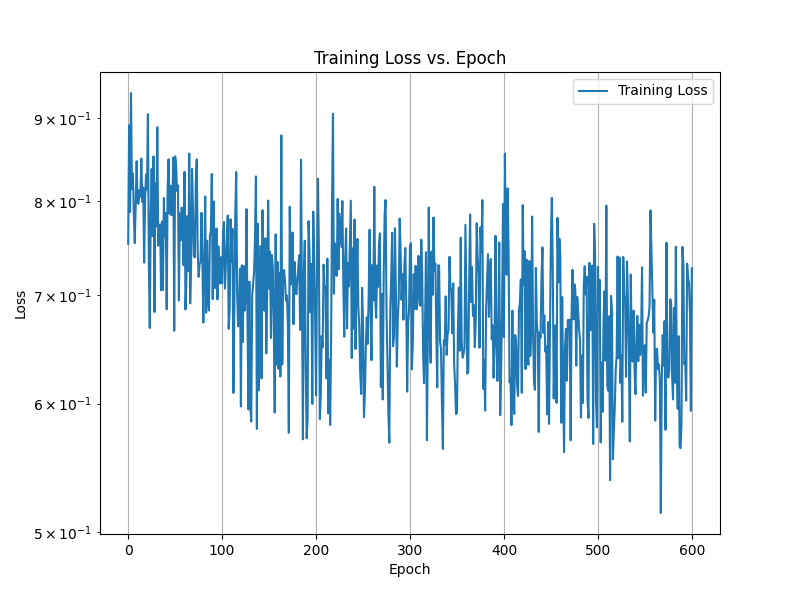

In [ ]:
# Extract epochs and losses
epochs = [entry[0] for entry in outputs]
losses = [entry[1].item() for entry in outputs]

# Plot loss as a function of epoch
plt.figure(figsize=(8, 6))
plt.plot(epochs, losses, marker='', label='Training Loss')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

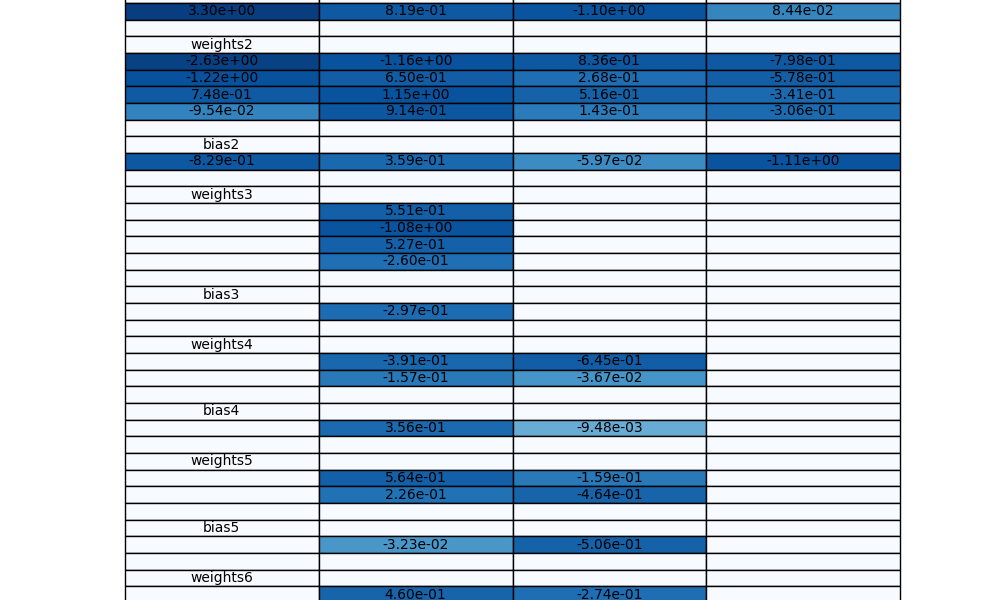

In [ ]:
import random
import string

max_neurons = 4
blank_layer = [None for _ in range(max_neurons)]

table_layers = []
for idx, param in enumerate(model.parameters()):
    layer = param.data
    num_parallel = layer.shape[0]
    side_padding = int((max_neurons - num_parallel)/2)
    
    if idx % 2 == 0:
        
        table_layer = blank_layer.copy()
        table_layer[0] = "weights" + str(idx//2+1)
        table_layers.append(table_layer)
        for i in range(layer.shape[1]):
            table_layer = blank_layer.copy()
            for j in range(num_parallel):
                table_layer[j+side_padding] = '{:.2e}'.format(layer[j][i].item())
            table_layers.append(table_layer)
        table_layers.append(blank_layer)
            
    else:  
        
        table_layer = blank_layer.copy()
        table_layer[0] = "bias" + str(idx//2+1)
        table_layers.append(table_layer)
        table_layer = blank_layer.copy()
        for j in range(num_parallel):
            table_layer[j+side_padding] = '{:.2e}'.format(layer[j].item())
        table_layers.append(table_layer)
        table_layers.append(blank_layer)

numeric_values = np.zeros((len(table_layers), max_neurons))
for i, row in enumerate(table_layers):
    for j, item in enumerate(row):
        if item not in (None, "weights1", "weights2", "bias1", "bias2"):  # Replace with relevant layer names
            try:
                numeric_values[i, j] = (float(item))
            except ValueError:
                pass
        
min_val, max_val = numeric_values.min(), numeric_values.max()


# Step 2: Apply a logarithmic transformation, setting a small threshold to avoid log(0)
threshold = 1e-5
log_values = np.log10(np.clip(np.abs(numeric_values), threshold, None))

# Normalize the log-scaled values to range between 0 and 1
normalized_values = (log_values - log_values.min()) / (log_values.max() - log_values.min())
colors = plt.cm.Blues(normalized_values)

        
# Plot the table
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

# Create table
table = plt.table(cellText=table_layers, cellColours=colors, loc='center', cellLoc='center')

plt.show()

In [ ]:
class Autoencoder2(nn.Module):
    def __init__(self, rp):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 3),
            nn.Sigmoid(),
            nn.Linear(3, 4),
            #nn.Sigmoid(),
            #nn.Linear(4, 4)
        )
        
        
        self.decoder = nn.Sequential(
            #nn.Linear(4, 4),
            #nn.Sigmoid(),
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 2)
        )
        
        self.rp = rp

    def encoder_nn(self, q):
        latent = self.encoder(q)
        J_h_inv_1 = latent[:,0:2]
        J_h_inv_2 = latent[:,2:4]
        J_h_inv = torch.stack((J_h_inv_1, J_h_inv_2), dim=1)
        return J_h_inv, latent
    
    def forward(self, q):
        J_h_inv, latent = self.encoder_nn(q)

        q_hat = self.decoder(latent)
        return J_h_inv, q_hat

/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202411291422.pth
Epoch:1, Loss:0.116696201
Weighted loss_diagonality_geo_mean: tensor(0.1167, grad_fn=<MseLossBackward0>)
Epoch:401, Loss:0.001742180
Weighted loss_diagonality_geo_mean: tensor(0.0017, grad_fn=<MseLossBackward0>)
Epoch:801, Loss:0.000723885
Weighted loss_diagonality_geo_mean: tensor(0.0007, grad_fn=<MseLossBackward0>)
Epoch:1201, Loss:0.000648134
Weighted loss_diagonality_geo_mean: tensor(0.0006, grad_fn=<MseLossBackward0>)


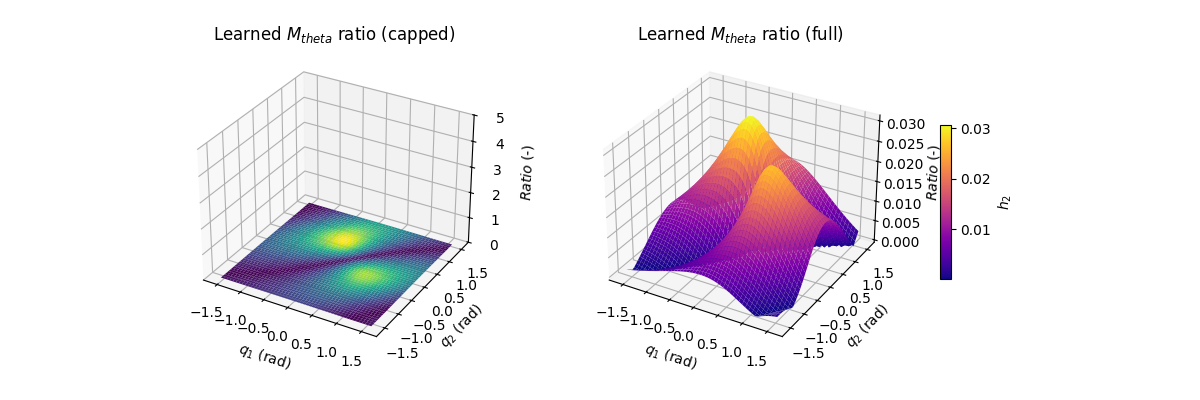

Epoch:1601, Loss:0.000735153
Weighted loss_diagonality_geo_mean: tensor(0.0007, grad_fn=<MseLossBackward0>)
Epoch:2001, Loss:0.000547089
Weighted loss_diagonality_geo_mean: tensor(0.0005, grad_fn=<MseLossBackward0>)
Epoch:2401, Loss:0.000701432
Weighted loss_diagonality_geo_mean: tensor(0.0007, grad_fn=<MseLossBackward0>)


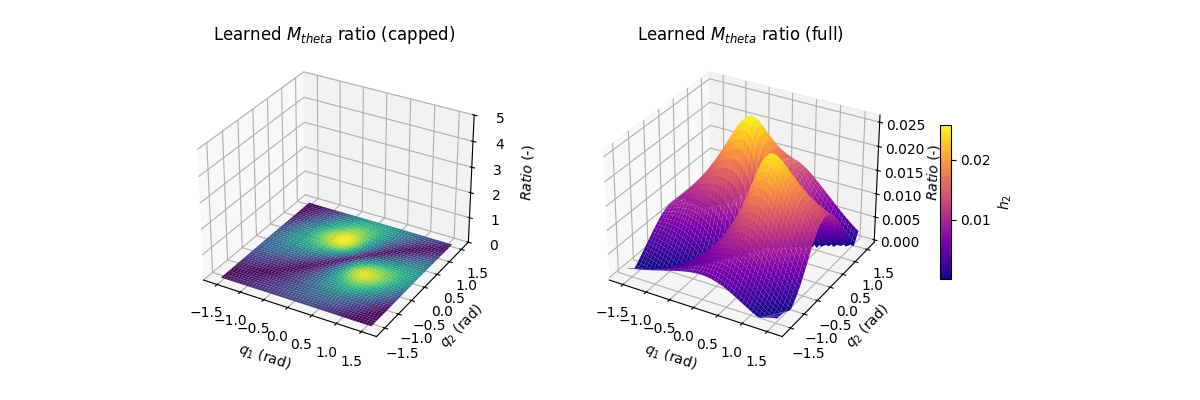

Model parameters saved to /home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202411291422.pth
CPU times: user 1min 23s, sys: 35.9 ms, total: 1min 23s
Wall time: 1min 23s


In [ ]:
%%time
%matplotlib widget

current_time = datetime.now().strftime("%Y%m%d%H%M")
save_directory = os.path.join(os.getcwd(), "Models")
os.makedirs(save_directory, exist_ok=True)
file_name = f"Lumped_Mass_{current_time}.pth"
file_path = os.path.join(save_directory, file_name)

load_path = os.path.normpath("/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202411271337.pth")


rp = robot_parameters.LUMPED_PARAMETERS
num_epochs = 2401

print(file_path)
model = Autoencoder2(rp).to(device)  # Move model to GPU
#model.load_state_dict(torch.load(load_path, weights_only=True))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)#, weight_decay=1e-6)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-2, alpha=0.99, eps=1e-08)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / num_epochs))



l_weights = [1,
             1,
             1e-1,
             1e-2]
outputs = []



plt.ion()

for epoch in range(num_epochs):
    for index, batch in enumerate(train_dataloader):
        batch_size = batch[0].shape[0]
        q = batch[0][:, 0:2].to(device)
        q.requires_grad = True
        q_d = batch[0][:, 2:4].to(device)
        
        J_h_inv, q_hat = model(q)  
        J_h_inv_trans = J_h_inv.transpose(1,2)
                
        matrices_vmap = torch.vmap(dynamics.dynamical_matrices, 
                                   in_dims=(None, 0, 0))

        M_q, C_q, G_q = matrices_vmap(rp, q, q_d)
        
        M_th, C_th, G_th = transforms.transform_dynamical_from_inverse(M_q, C_q, G_q, J_h_inv, J_h_inv_trans)      
        
        #loss_reconstruction = loss_terms.loss_reconstruction(q, q_hat)
        loss_diagonality_geo_mean = loss_terms.loss_diagonality_geo_mean(M_th, batch_size, device)
        loss_diagonality_trace = loss_terms.loss_diagonality_trace(M_th, batch_size, device)
        loss_diagonality_smallest = loss_terms.loss_diagonality_smallest(M_th, batch_size, device)
        ### Use J@J^T = eye to avoid needing to calculate the Jacobian inverse for efficiency. 
        #loss_J_h_unitary = loss_terms.loss_J_h_unitary(J_h, batch_size, device)
        #loss_J_h_cheat = loss_terms.loss_J_h_cheat(J_h, J_h_ana)
        #loss_M_th_cheat = loss_terms.loss_M_th_cheat(M_th, rp, q, q_d, batch_size)
        #l1_norm = loss_terms.loss_l1(model)
        
        #loss_diagonality = 10 * loss_diagonality_geo_mean + loss_diagonality_smallest + 100 * loss_diagonality_trace
        loss_diagonality = loss_diagonality_geo_mean


        loss = loss_diagonality #+ 0.2 * loss_J_h_unitary

        
        #loss = loss_J_h_cheat


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

 

    if epoch % 400 == 0:
        print(f'Epoch:{epoch+1}, Loss:{loss.item():.9f}')#, LR:{scheduler.get_last_lr():.7f}')
        print("Weighted loss_diagonality_geo_mean:", loss_diagonality_geo_mean)
        #print("Weighted loss_diagonality_smallest:", loss_diagonality_smallest)
        #print("Weighted loss_diagonality_trace:", 100 * loss_diagonality_trace)
        #print("Weighted loss Jh unitary:", 0.2 * loss_J_h_unitary)
    if epoch % 1200 == 0 and epoch > 0:
        #plotters.plot_h2(model, device, rp, epoch)
        #plotters.plot_J_h(model, device, rp, epoch, plot_index = 0)
        #plotters.plot_J_h(model, device, rp, epoch, plot_index = 1)
        plotters.plot_decoupling_inv(model, device, rp, epoch)
    scheduler.step()

    outputs.append((epoch, loss, q, q_hat, J_h_inv, M_th))


torch.save(model.state_dict(), file_path)
print(f"Model parameters saved to {file_path}")